# Oklahoma County Property Analysis

In [454]:
# Install required libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Import CSV file

In [455]:
# Read the CSV file into a DataFrame
df = pd.read_csv('output.csv')

# Convert string representations of Python dictionaries back into the correct data type
df['market_values'] = df['market_values'].apply(ast.literal_eval)
df['sales_prices'] = df['sales_prices'].apply(ast.literal_eval)

## Clean Data and Add Columns

In [456]:
# Create new columns for 'price/square foot' and 'value change'

# Extract the most recent sales price and market value
get_most_recent = lambda x: next(iter(x.values())) if x else None
df['most_recent_sales_price'] = df['sales_prices'].apply(get_most_recent)
df['most_recent_market_value'] = df['market_values'].apply(get_most_recent)

# Calculate price/square foot
df['price/square_foot'] = df['most_recent_sales_price'] / df['square_feet']

# Calculate value change
df['value_change'] = df['most_recent_market_value'] - df['most_recent_sales_price']

# Display the DataFrame
df


,address,square_feet,market_values,sales_prices,most_recent_sales_price,most_recent_market_value,price/square_foot,value_change
0,1000 PEDALERS LN,1024.0,"{2023: 331500, 2022: 284500, 2021: 243000, 202...",{2019: 232500},232500.0,331500.0,227.050781,99000.0
1,1001 PEDALERS LN,1167.0,"{2023: 369000, 2022: 317000, 2021: 267500, 202...",{2019: 246000},246000.0,369000.0,210.796915,123000.0
2,1004 PEDALERS LN,766.0,"{2023: 281500, 2022: 242000, 2021: 210500, 202...","{2020: 215000, 2019: 197500}",215000.0,281500.0,280.678851,66500.0
3,1005 PEDALERS LN,756.0,"{2023: 277500, 2022: 237500, 2021: 208000, 202...",{2019: 191000},191000.0,277500.0,252.645503,86500.0
4,1008 PEDALERS LN,1164.0,"{2023: 353500, 2022: 303000, 2021: 259500, 202...",{2019: 248500},248500.0,353500.0,213.487973,105000.0
...,...,...,...,...,...,...,...,...
160,1821 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},429000.0,484000.0,279.478827,55000.0
161,1825 WHEELER ST,1498.0,"{2023: 430000, 2022: 430000}",{2021: 434000},434000.0,430000.0,289.719626,-4000.0
162,1829 WHEELER ST,1496.0,"{2023: 474000, 2022: 410000}",{2021: 429000},429000.0,474000.0,286.764706,45000.0
163,1833 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},429000.0,484000.0,279.478827,55000.0


## Market Value Linear Regression

MSE: 5125526698.71516
RMSE: 71592.78384526726
R2: 0.8563964937617996


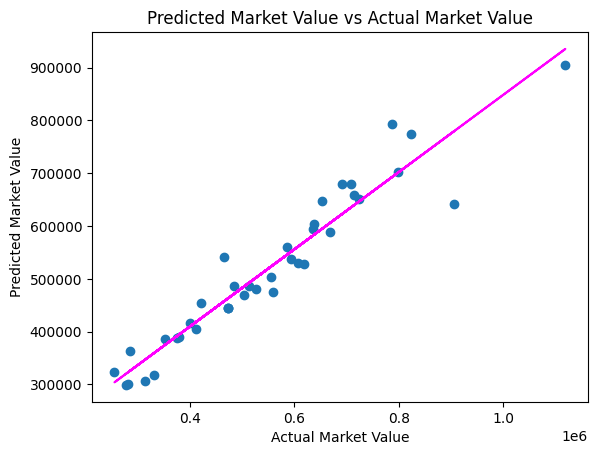

In [457]:
# Clean the data and break into features and labels
cleaned_df = df.dropna(subset=['square_feet', 'most_recent_market_value'])
X = cleaned_df[['square_feet']].values
y = cleaned_df['most_recent_market_value'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
market_model = LinearRegression().fit(X_train, y_train)
predictions = market_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Market Value')
plt.ylabel('Predicted Market Value')
plt.title('Predicted Market Value vs Actual Market Value')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Sales Price Linear Regression

MSE: 3346309143.038763
RMSE: 57847.29157911166
R2: 0.8537850853815268


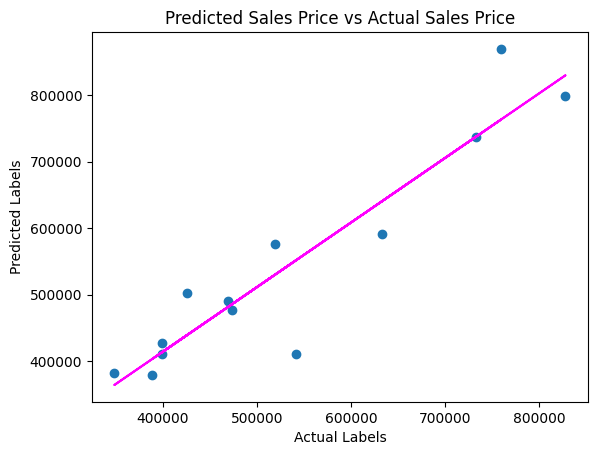

In [458]:
# Clean the data by removing sales data from before 2022 and break into features and labels
cleaned_df = df[df['sales_prices'].apply(lambda x: next(iter(x), None)) >= 2022]
cleaned_df = cleaned_df.dropna(subset=['square_feet', 'most_recent_sales_price'])
X = cleaned_df[['square_feet']].values
y = cleaned_df['most_recent_sales_price'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
sales_model = LinearRegression().fit(X_train, y_train)
predictions = sales_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predicted Sales Price vs Actual Sales Price')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Predictions

In [459]:
# Allows user to input square footage to be used in the prediction
sqft = int(input("Enter a square footage amount (an integer) to predict sales price and market value:"))

In [460]:
# Predict sales price
predicted_sales = sales_model.predict([[sqft]])[0]
formatted_sales_price = "${:,.0f}".format(predicted_sales)
print("Predicted Sales Price: ", formatted_sales_price)

# Predict market value
predicted_market_value = market_model.predict([[sqft]])[0]
formatted_market_value = "${:,.0f}".format(predicted_market_value)
print("Predicted Market Value: ", formatted_market_value)

Predicted Sales Price:  $528,425
Predicted Market Value:  $502,520
